In [1]:
%%time
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import random

np.set_printoptions(precision=4, suppress=True)

os.environ["KERAS_BACKEND"] = "tensorflow"


def clean_session():
    tf.keras.backend.clear_session()
    seed_value = 42

    os.environ['PYTHONHASHSEED'] = str(seed_value)

    random.seed(seed_value)

    np.random.seed(seed_value)

    tf.random.set_seed(seed_value)
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


def plot_results(x_testing, t_testing, t_predictions):
    fig2, ax2 = plt.subplots(1, 2)
    fig2.set_size_inches(11, 5)

    ax2[0].scatter(x_testing[t_testing == 0, 0], x_testing[t_testing == 0, 1], c="#a49d78", marker='x', label='Class 0')
    ax2[0].scatter(x_testing[t_testing == 1, 0], x_testing[t_testing == 1, 1], c="#1f3e6e", marker='o', label='Class 1')

    ax2[0].format_coord = lambda x, y: f'x1={x:.2f}, x2={y:.2f}'

    ax2[0].set_title(r'Test Data')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$', rotation=0)
    ax2[0].legend()
    ax2[0].grid(True)

    ax2[1].scatter(x_testing[t_predictions == 0, 0], x_testing[t_predictions == 0, 1], c="#a49d78", marker='x',
                   label='Class 0')
    ax2[1].scatter(x_testing[t_predictions == 1, 0], x_testing[t_predictions == 1, 1], c="#1f3e6e", marker='o',
                   label='Class 1')

    ax2[1].format_coord = lambda x, y: f'x1={x:.2f}, x2={y:.2f}'

    ax2[1].set_title(r'Classification')
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$', rotation=0)
    ax2[1].legend()
    ax2[1].grid(True)


data = 'data'


def plot_data(x, t, title):
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(5, 5)
    ax1.scatter(x[t == 0, 0], x[t == 0, 1], c="#a49d78", marker='o', label='Class 1')
    ax1.scatter(x[t == 1, 0], x[t == 1, 1], c="#1f3e6e", marker='x', label='Class 0')
    ax1.format_coord = lambda x, y: f'x1={x:.2f}, x2={y:.2f}'
    ax1.set_title(title)
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$', rotation=0)
    ax1.legend()
    ax1.grid(True)


def train(X, y, model, optimizer, loss, metrics):
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    clean_session()

    print('\n', ' Beginning training... ', '\n')
    model.fit(X_train, y_train, epochs=2000, verbose=0)
    print('\n', ' Training complete!', '\n')
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('\n', f'Test accuracy: {"{:.2%}".format(test_acc)}')

    probability_model_output = model.predict(X_test)
    probabilities = np.hstack((1 - probability_model_output, probability_model_output))
    t_predictions = np.argmax(probabilities, 1)
    plot_results(X_test, y_test, t_predictions)



CPU times: user 3.55 s, sys: 779 ms, total: 4.33 s
Wall time: 1min 30s


In [2]:
N = 5000  # households with at least 2 kids

import pandas as pd

census_data = pd.read_csv(os.path.join(data, 'usa_00001.csv'))
census_data = census_data.sort_values(by=['CLUSTER', 'AGE'])

In [3]:
count = 0
families = dict()
max_age = 18


def gather(row):
    global count, families, N
    key = int(row['CLUSTER'])
    age = int(row['AGE'])
    info = families.get(key, [])
    if len(info) == 0 and count > N:
        return []
    if len(info) == 1:
        count = count + 1
    if age < max_age:
        info.append({
            'SEX': int(row['SEX']-1),
            'AGE': age,
        })
        families[key] = info
    return []


_ = census_data.apply(lambda row: gather(row), axis=1)


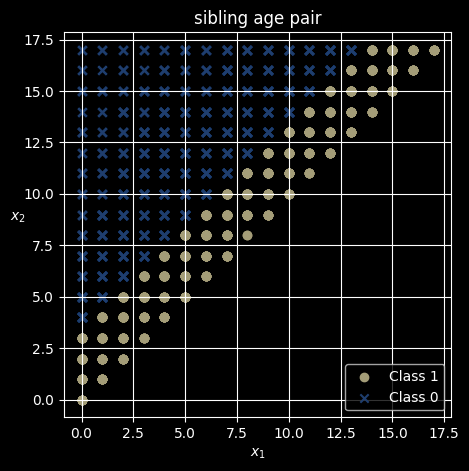

In [4]:
# look at sibling pairs
gap = 4
groups = list(filter(lambda x: len(x) >= 2, families.values()))
from itertools import combinations

ages_by_household = [list(combinations([kid['AGE'] for kid in group], 2)) for group in groups]
pairs = [item for sublist in ages_by_household for item in sublist]
np_pairs = np.array(pairs, dtype=int)
X = np_pairs
y = ((np_pairs[:, 1] - np_pairs[:, 0]) >= gap).astype(int)
plot_data(X, y, 'sibling age pair')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)


  Beginning training...  


  Training complete! 


 Test accuracy: 87.07%
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


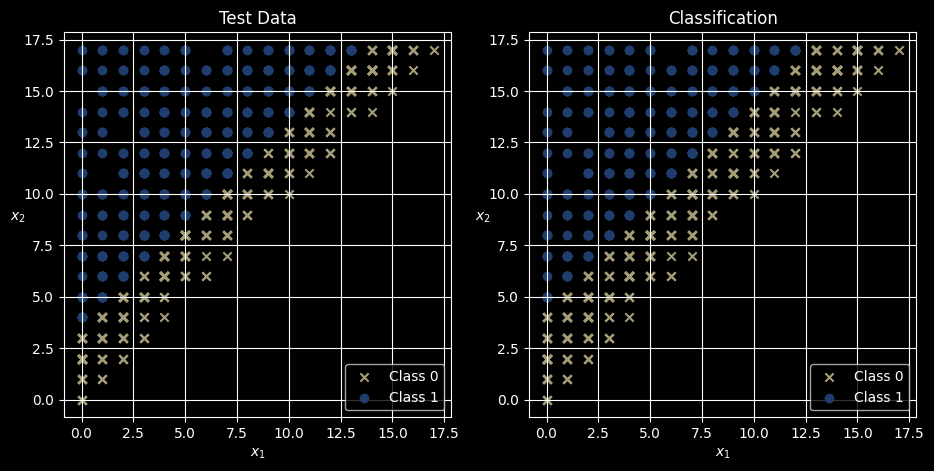

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),  # Define input shape
    tf.keras.layers.Dense(1, activation='linear')  # Direct output layer
])

train(X, y, model,
      tf.keras.optimizers.Adam(),
      tf.keras.losses.MeanSquaredError(),
      [tf.keras.metrics.BinaryAccuracy()])


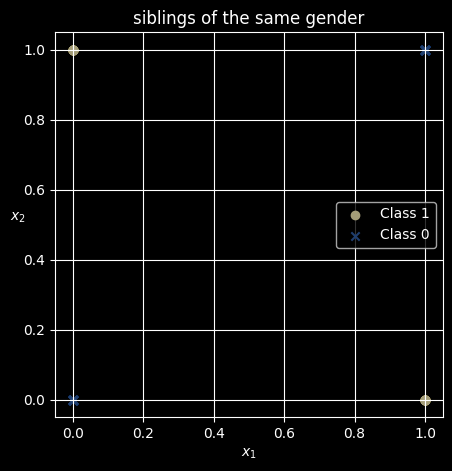

In [6]:
genders_by_household = [list(combinations([kid['SEX'] for kid in group], 2)) for group in groups]
pairs = [item for sublist in genders_by_household for item in sublist]
np_pairs = np.array(pairs, dtype=float)
y = (np_pairs[:, 1] == np_pairs[:, 0]).astype(int)
X = np_pairs

plot_data(X, y, 'siblings of the same gender')


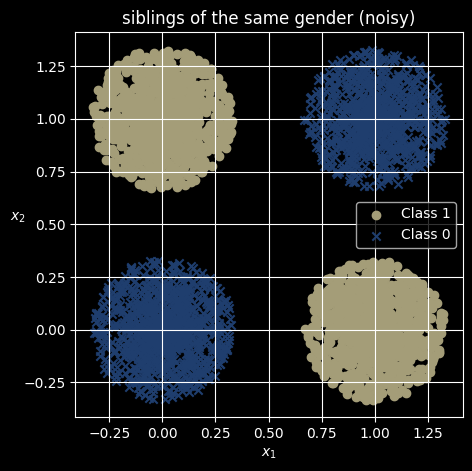

In [7]:
count = np_pairs.shape[0]
theta = 2 * np.pi * np.random.random_sample(count)
unit = np.vstack((np.cos(theta), np.sin(theta))).T
radius = np.random.rand(count).reshape(-1, 1)
X = np_pairs + unit * radius / 3.0
plot_data(X, y, 'siblings of the same gender (noisy)')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)


  Beginning training...  


  Training complete! 


 Test accuracy: 33.41%
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


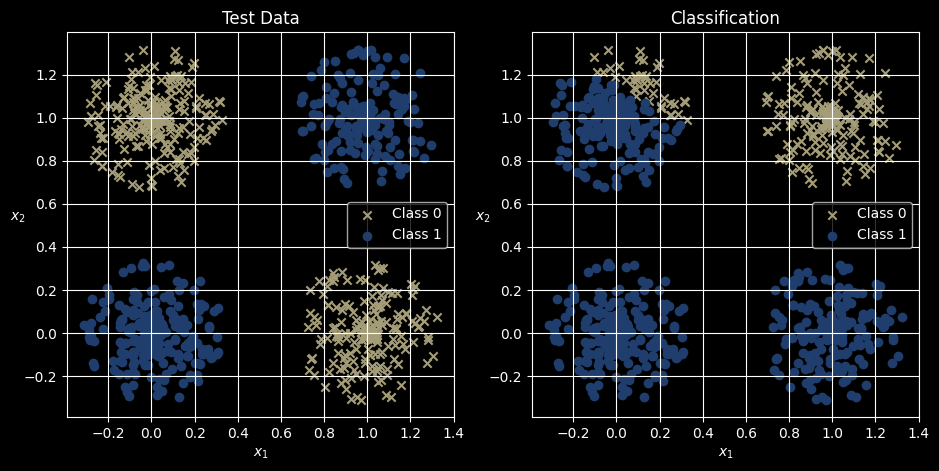

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),  # Define input shape
    tf.keras.layers.Dense(1, activation='linear')  # Direct output layer
])

train(X, y, model,
      tf.keras.optimizers.Adam(),
      tf.keras.losses.MeanSquaredError(),
      [tf.keras.metrics.BinaryAccuracy()])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)


  Beginning training...  


  Training complete! 


 Test accuracy: 100.00%
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step


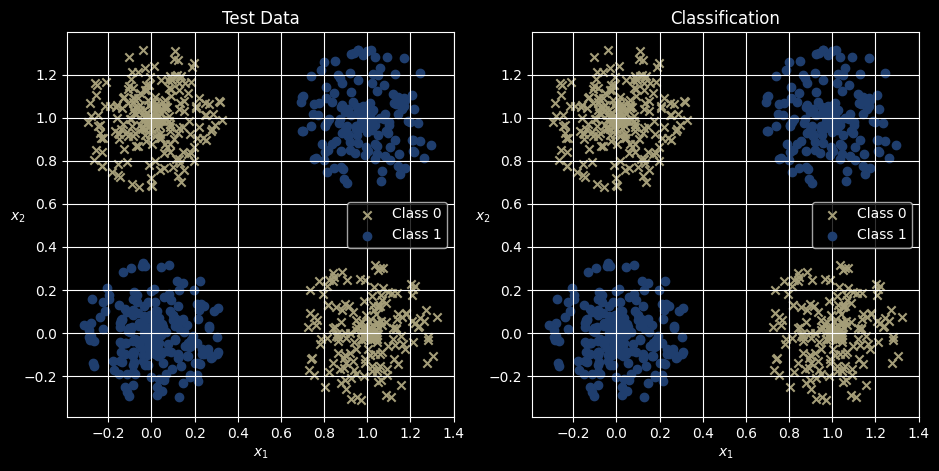

In [9]:
model = keras.Sequential([
    tf.keras.layers.Input((2,)),
    tf.keras.layers.Dense(units=4, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

train(X, y, model,
      tf.keras.optimizers.Adam(),
      tf.keras.losses.BinaryCrossentropy(),
      [tf.keras.metrics.BinaryAccuracy()])
